In [1]:
import torch
import emoji
import os
import sys
import pandas as pd
import numpy as np
import scipy.stats as ss
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.insert(0, '../')

from tqdm import tqdm
from config import GPT2EmojiConfig
from model import GPT2LMEmojiModel
from transformers import GPT2Tokenizer
from run_language_modeling import load_and_cache_examples, targets_mask
from sst_binary import sst_binary
from utils import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


MODEL_CLASSES = {
    "gpt2": (GPT2EmojiConfig, GPT2LMEmojiModel, GPT2Tokenizer),
}

MODEL_PATH = '../checkpoint-180000'

args = torch.load(os.path.join(MODEL_PATH, 'training_args.bin'))

config_class, model_class, tokenizer_class = MODEL_CLASSES['gpt2']

config = config_class.from_pretrained(MODEL_PATH)

tokenizer = tokenizer_class.from_pretrained(MODEL_PATH)

model = model_class.from_pretrained(
            MODEL_PATH,
            config=config,
)

map_target_to_token_id = dict(
        zip(range(0, len(emoji.UNICODE_EMOJI.keys())), tokenizer.encode(list(emoji.UNICODE_EMOJI.keys())))
)


Bad key "text.kerning_factor" on line 4 in
/home/jkarabl/anaconda3/envs/emoji-gpt2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Token indices sequence length is longer than the specified maximum sequence length for this model (2811 > 1024). Running this sequence through the model will result in indexing errors


In [2]:
DATASETS = [
    'Olympic',
    'PsychExp',
    'SCv1',
    'SCv2-GEN',
    'SE0714',
    'SS-Twitter',
    'SS-Youtube',
]
DIR = '../data'
FILENAME_RAW = 'raw.pickle'
CLASSES = 'negative, positive'.split(', ')
TRAIN_SIZE = 1000

In [3]:
def load_dataset(dataset):
    print(dataset)
    DATASET_PATH = f'{DIR}/{dataset}/{FILENAME_RAW}'
    with open(DATASET_PATH, 'rb') as file:
        data = pickle.load(file, fix_imports=True, encoding='bytes')
    
    # Decode data
    texts = [str(x) for x in data[b'texts']]
    # Extract labels
    labels = [x[b'label'] for x in data[b'info']]
    return texts, labels

def decode(y_in):
    y_out = []
    for y in y_in:
        y_out.append(np.argmax(y))
    return y_out

In [4]:
X, y = load_dataset(DATASETS[6])

SS-Youtube


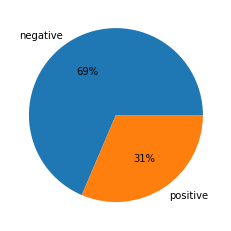

In [6]:
df = pd.DataFrame({'X': X, 'y': y})
ax = df.y.value_counts().plot.pie(labels=CLASSES, autopct='%1.0f%%')
ax.set_ylabel(None)
plt.savefig('SS-Youtube-classes.pdf', dpi=300)

In [7]:
pd.set_option('display.max_colwidth', 1000)

In [8]:
df.loc[df.y == 0]

,X,y
0,when the time comes for all to know it will be to late,0
1,"@princessofportk The first are a pair of devil horns, and the second look like a pair of cat or feline like ears",0
2,"I gotta feeling they partlishly took it off fomr MIB anime ep form the american unless they took that one off from it, but the story is really different.",0
3,"Not a lot of ""removing"" going on here... bucket teeth removal maybe.",0
4,"@qingian they represent HK. but considering how their last names are spelled, i think they are from China. they don't get to represent China because they're not as good as Ma Long, Zhang Jike and Xu XIn.",0
...,...,...
2112,@MsEllz21 stale,0
2114,fucker,0
2117,18 people missed the like button.....,0
2120,What?,0


In [9]:
df.loc[df.y == 1]

,X,y
5,Pastor Morgan brought a powerful encouraging word to us in that service. I really enjoyed her. To GOD be the Glory!!!,1
7,Absolutely awesome!! Impressive.,1
9,loved the video joey it was awesome :O,1
10,this is such a high quality game i cannot believe it. it is a lot greater than mw1. ive only just attained the 2nd prestige ! i'm so delighted. got the game only yesterday evening from mw2forfreeYinfo (replace Y with . ) but im undoubtedly annihilating most people!,1
11,epic song fo sho,1
...,...,...
2137,"Lol, FIRE IS HOT.",1
2138,Great video I love this song I heard it on OTH in an LP scene 3,1
2139,"Rickie, you are so inspiring! This video never fails to help me find one more ounce of energy and joy after a long day of work.",1
2140,"Thank you Herve, your work has made my day! Bravo!",1


In [7]:
Xt = tokenize(X, tokenizer)

In [8]:
trXt, teXt, trY, teY = train_test_split(Xt, y, train_size=TRAIN_SIZE, random_state=42)

In [9]:
mean_preds = predict_mean(trXt, model, tokenizer, map_target_to_token_id)

100%|██████████| 1000/1000 [02:03<00:00,  8.08it/s]


In [10]:
last_preds = predict_last(trXt, model, tokenizer, map_target_to_token_id)

100%|██████████| 1000/1000 [01:55<00:00,  8.69it/s]


In [11]:
max_preds = predict_max(trXt, model, tokenizer, map_target_to_token_id)

100%|██████████| 1000/1000 [01:55<00:00,  8.69it/s]


In [12]:
mean_cm = pd.crosstab(pd.Series(mean_preds), pd.Series(trY))
mean_cm

col_0,0,1
row_0,,
✨,1,2
❤,0,8
🎧,1,0
🎶,1,1
👀,2,11
👇,0,10
👉,0,1
👋,0,1
👍,0,41


In [13]:
last_cm = pd.crosstab(pd.Series(last_preds), pd.Series(trY))
last_cm

col_0,0,1
row_0,,
✨,1,6
❤,0,13
🌞,0,1
🌟,1,1
🍀,0,2
🎧,1,0
🎶,2,4
👀,4,20
👇,0,4


In [14]:
max_cm = pd.crosstab(pd.Series(max_preds), pd.Series(trY))
max_cm

col_0,0,1
row_0,,
✅,0,1
✨,1,1
❤,0,3
🇺,1,0
🌊,1,0
🌍,1,0
🌞,0,1
🌟,0,2
🌱,0,1


In [15]:
cramers_corrected_stat(mean_cm.to_numpy())

0.41877703830387697

In [16]:
cramers_corrected_stat(last_cm.to_numpy())

0.46682674232550947

In [17]:
cramers_corrected_stat(max_cm.to_numpy())

0.39367314158267297

In [18]:
theil_u(trY, mean_preds)

0.21227387850455948

In [19]:
theil_u(trY, last_preds)

0.24422281945316343

In [20]:
theil_u(trY, max_preds)

0.20098192920466604

## Logreg

In [21]:
Xtrans_last = transform_last(X, model, tokenizer, args)

100%|██████████| 2142/2142 [04:14<00:00,  8.42it/s]


In [22]:
Xtrans_mean = transform_mean(X, model, tokenizer, args)

100%|██████████| 2142/2142 [08:44<00:00,  4.08it/s]


In [23]:
Xtrans_max = transform_max(X, model, tokenizer, args)

100%|██████████| 2142/2142 [04:35<00:00,  7.77it/s]


In [30]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_last, y, train_size=TRAIN_SIZE, random_state=42)

In [31]:
model, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs')
model, C, scores

(LogisticRegression(C=0.03125, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.03125,
 [0.8957968476357268,
  0.8957968476357268,
  0.8966725043782837,
  0.8975481611208407,
  0.8975481611208407,
  0.8861646234676007,
  0.8835376532399299,
  0.8800350262697023,
  0.8774080560420315])

In [32]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_mean, y, train_size=TRAIN_SIZE, random_state=42)

In [33]:
model, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs')
model, C, scores

(LogisticRegression(C=0.00390625, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=1000000, multi_class='auto', n_jobs=None,
                    penalty='l2', random_state=51, solver='lbfgs', tol=0.0001,
                    verbose=0, warm_start=False),
 0.00390625,
 [0.8870402802101576,
  0.8852889667250438,
  0.8835376532399299,
  0.8800350262697023,
  0.8835376532399299,
  0.882661996497373,
  0.8774080560420315,
  0.873029772329247,
  0.87215411558669])

In [34]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_max, y, train_size=TRAIN_SIZE, random_state=42)

In [35]:
model, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs')
model, C, scores

(LogisticRegression(C=0.0078125, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=1000000, multi_class='auto', n_jobs=None,
                    penalty='l2', random_state=51, solver='lbfgs', tol=0.0001,
                    verbose=0, warm_start=False),
 0.0078125,
 [0.862521891418564,
  0.8669001751313485,
  0.8669001751313485,
  0.8633975481611208,
  0.8642732049036778,
  0.8590192644483362,
  0.8555166374781086,
  0.8528896672504378,
  0.8485113835376532])

## Vanilla GPT-2

In [5]:
from transformers import GPT2Model

In [6]:
model_version = 'gpt2'
model_gpt2 = GPT2Model.from_pretrained(model_version)
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained(model_version)

In [7]:
Xtrans_gpt2 = transform_gpt2(X, model_gpt2, tokenizer_gpt2)

100%|██████████| 2142/2142 [02:24<00:00, 14.83it/s]


In [8]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_gpt2, y, train_size=TRAIN_SIZE, random_state=42)

lr, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
lr, C, scores

(LogisticRegression(C=0.0625, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.0625,
 [0.7915735618950654,
  0.8072573839662447,
  0.8313210119678838,
  0.8368380996848372,
  0.8410338645196493,
  0.8349156365812673,
  0.834850864571778,
  0.8258999254271409,
  0.8252753977968176])

In [9]:
Xtrans_emoji = transform_emoji(X, model, tokenizer)

100%|██████████| 2142/2142 [07:11<00:00,  4.97it/s]


In [10]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_emoji, y, train_size=TRAIN_SIZE, random_state=42)

lr, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
lr, C, scores

(LogisticRegression(C=0.0078125, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=1000000, multi_class='auto', n_jobs=None,
                    penalty='l2', random_state=51, solver='lbfgs', tol=0.0001,
                    verbose=0, warm_start=False),
 0.0078125,
 [0.86687649355948,
  0.8760097281334144,
  0.8739432236023046,
  0.8737389665234807,
  0.874145911395195,
  0.8698102145400851,
  0.8686708531224108,
  0.8647529831241825,
  0.8599426034486988])